# Building a Spam Filter with Naive Bayes

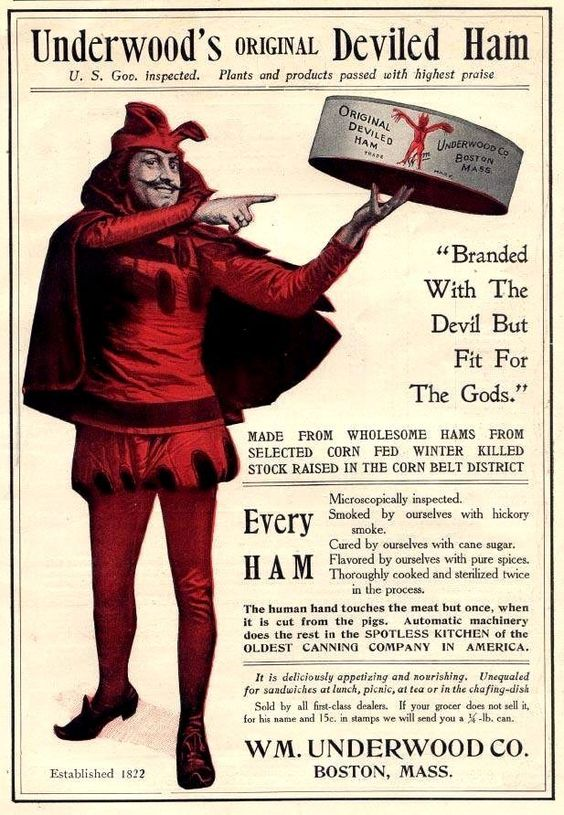

In this project, I'm going to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. Goal this project -  write a program that classifies new messages with an accuracy greater than 80% — so I expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam) categories.

For training the algorithm, I using  a dataset of 5,572 SMS messages that are already classified by humans. The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip" target="_blank">downloaded</a> from <a href="https://archive.ics.uci.edu/ml/index.php" target="_blank"> The UCI Machine Learning Repository</a>. The data collection process is described in more details on <a href="https://archive.ics.uci.edu/ml/datasets/sms+spam+collection" target="_blank">this page</a>, where you can also find some of the papers authored by Tiago A. Almeida and José María Gómez Hidalgo.

## Exploring the Dataset

Import required library and open dataset:

,cat,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


,cat,text
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


'Numbers messages by category '

ham     4825
spam     747
Name: cat, dtype: int64

'Share messages by category in %'

ham     86.593683
spam    13.406317
Name: cat, dtype: float64

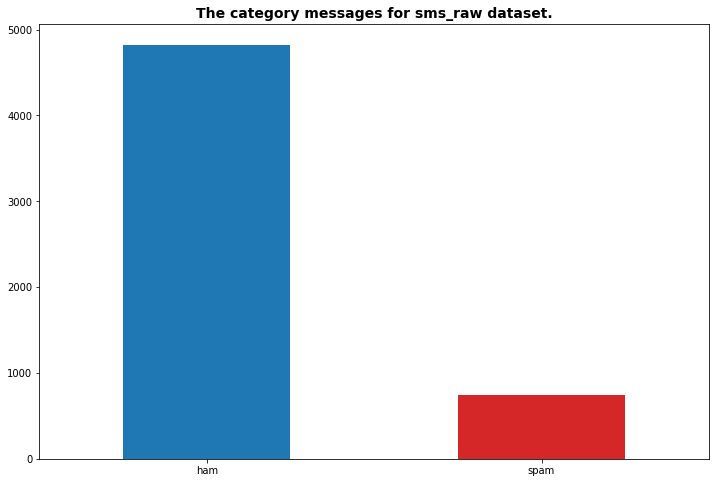

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import re

# Open dataset - cat column for `ham`/`spam`, text column - message 
sms_raw = pd.read_csv('data/SMSSpamCollection', sep='\t', 
                       header=None, names=['cat', 'text'])

# View head and tail, and general info for dataset
display(sms_raw.head())
display(sms_raw.tail())
display("Numbers messages by category ",sms_raw.cat.value_counts())
display("Share messages by category in %",sms_raw.cat.value_counts(normalize = True)*100)
# Plot messages by category
fig, ax = plt.subplots(figsize = (12, 8))
ax = sms_raw.cat.value_counts().plot.bar(rot = 0, color=['C0', 'C3'])
ax.set_title("The category messages for sms_raw dataset.", fontsize=14, 
          fontweight="bold")
plt.show()
# Check nan values
sms_raw.info()

Write function `word_stat(df)` and collect more detailed statical information about words in the `sms_raw` dataset :

In [2]:
def word_stat(df):
    """
    Calculate word statistics for inpur datasets 
    ----------
    df : sms dataset
    Returns
    -------
    ham_word, spam_word, total_word dataframe with stats
    """
    ham_word = {}
    spam_word  = {}
    total_word = {}
    sms = df.copy()
    # iteration of each row in dataset and extract unique words in dictionaries
    for index, row in sms.copy().iterrows():
        message_row = re.sub(r"(\W+)", " ", row[1]).lower().split()
        for word in message_row:
            if word not in total_word:
                total_word[word] = 1
            else:
                total_word[word] += 1
        if row[0] == "ham":
            for word in message_row:
                if word not in ham_word:
                    ham_word[word] = 1
                else:
                    ham_word[word] += 1
        else:
            for word in message_row:
                if word not in spam_word:
                    spam_word[word] = 1
                else:
                    spam_word[word] += 1
    # Convert dictionary to dataframes
    ham_word = pd.DataFrame.from_dict(ham_word, orient="index").reset_index()
    ham_word = ham_word.rename(columns={'index':'word', 0: "times"})
    spam_word = pd.DataFrame.from_dict(spam_word, orient="index").reset_index()
    spam_word = spam_word.rename(columns={'index':'word', 0: "times"})
    total_word = pd.DataFrame.from_dict(total_word, orient="index").reset_index()
    total_word = total_word.rename(columns={'index':'word', 0: "times"})
    return ham_word, spam_word, total_word

ham_raw, spam_raw, total_raw = word_stat(sms_raw)

ham_unique = ham_raw.shape[0]
ham_count = ham_raw.times.sum()

spam_inique = spam_raw.shape[0]
spam_count = spam_raw.times.sum()
 
total_inique = total_raw.shape[0]
total_count = total_raw.times.sum()

print (f"The ham category in the sms_raw datset, total unique  words: {ham_unique:,}, \
total words: {ham_count:,}.")
print (f"\nThe spam category in the sms_raw datset, total unique  words:\
{spam_inique:,}, total words: {spam_count:,}.")
print (f"\nThe sms_raw datset - total unique  words: {total_inique:,}, total words: \
{total_count:,}.")
print(f"\nThe share spam  for unique total words : {spam_inique/total_inique:.3%}, \
\nthe share spam word numbers for total word numbers : {spam_count/total_count:.3%}")

The ham category in the sms_raw datset, total unique  words: 6,943, total words: 71,347.

The spam category in the sms_raw datset, total unique  words:2,895, total words: 19,036.

The sms_raw datset - total unique  words: 8,753, total words: 90,383.

The share spam  for unique total words : 33.074%, 
the share spam word numbers for total word numbers : 21.061%


It seen, that `total_unique`  words = 8,753, and less than sum  `ham_unique` and `spam_unique` hence the part of  same words are contained in the `ham` and the `spam` messages - see bellow on the intersected words in the `ham_raw` and `spam_raw` datasets.

In [3]:
ham_raw.sort_values("times", ascending = False).head(10)

,word,times
35,i,2960
103,you,1948
41,to,1562
99,the,1133
114,a,1070
24,u,1033
85,and,858
7,in,823
55,me,777
48,my,754


In [4]:
spam_raw.sort_values("times", ascending = False).head(10)

,word,times
7,to,691
4,a,380
70,call,355
46,you,297
79,your,264
0,free,224
3,2,207
89,the,206
48,for,204
36,now,199


## Split `sms_raw` dataset into training and test datasets

In [5]:
# Randomize dataset
sms_rand = sms_raw.copy().sample(frac = 1, random_state = 1)

# Calculate index - the 80% lenth of sms_raw dataset
train_index = int(round(len(sms_rand) * 0.8))

# Split for train and test df
sms_train = sms_rand.iloc[:train_index,:].reset_index(drop = True)
sms_test = sms_rand.iloc[train_index:,:].reset_index(drop = True)


# Display head and tail  and general info for train set
print("1. sms_train info")
display(sms_train.head())
display(sms_train.tail())
display(sms_train.info())

# Show margin values for train set
print("sms_train margin category")
display(sms_train.cat.value_counts())

# Show in percent train set
print("sms_train share % category")
display(sms_train.cat.value_counts(normalize=True)*100.0)



# Display head and tail  and general info for train set
print("\n2. sms_test info")
display(sms_test.head())
display(sms_test.tail())
display(sms_test.info())

# Show margin values for test info
print("sms_test margin category")
display(sms_test.cat.value_counts())

# Show in percent test info
print("sms_train share % category") 
display(sms_test.cat.value_counts(normalize=True)*100.0)

1. sms_train info


,cat,text
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


,cat,text
4453,ham,"Sorry, I'll call later in meeting any thing re..."
4454,ham,Babe! I fucking love you too !! You know? Fuck...
4455,spam,U've been selected to stay in 1 of 250 top Bri...
4456,ham,Hello my boytoy ... Geeee I miss you already a...
4457,ham,Wherre's my boytoy ? :-(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     4458 non-null   object
 1   text    4458 non-null   object
dtypes: object(2)
memory usage: 69.8+ KB


None

sms_train margin category


ham     3858
spam     600
Name: cat, dtype: int64

sms_train share % category


ham     86.54105
spam    13.45895
Name: cat, dtype: float64


2. sms_test info


,cat,text
0,ham,Later i guess. I needa do mcat study too.
1,ham,But i haf enuff space got like 4 mb...
2,spam,Had your mobile 10 mths? Update to latest Oran...
3,ham,All sounds good. Fingers . Makes it difficult ...
4,ham,"All done, all handed in. Don't know if mega sh..."


,cat,text
1109,ham,"We're all getting worried over here, derek and..."
1110,ham,Oh oh... Den muz change plan liao... Go back h...
1111,ham,CERI U REBEL! SWEET DREAMZ ME LITTLE BUDDY!! C...
1112,spam,Text & meet someone sexy today. U can find a d...
1113,ham,K k:) sms chat with me.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     1114 non-null   object
 1   text    1114 non-null   object
dtypes: object(2)
memory usage: 17.5+ KB


None

sms_test margin category


ham     967
spam    147
Name: cat, dtype: int64

sms_train share % category


ham     86.804309
spam    13.195691
Name: cat, dtype: float64

It  seen  that `sms_raw` split correctly and  the and integer values of percentages of spam/ham messages in each dataset  `sms_train` and `sms_test` are equal each other  and parent `sms_raw` dataset.

Extract the  statical information from  `sms_train` dataset  using  `word_stat(df)` function:

In [6]:
# Extract  and display information about train dataset
train_ham, train_spam, train_total = word_stat(sms_train)

train_ham_unique = train_ham.shape[0]
train_ham_count = train_ham.times.sum()

train_spam_inique = train_spam.shape[0]
train_spam_count = train_spam.times.sum()
 
train_total_inique = train_total.shape[0]
train_total_count = train_total.times.sum()

print (f"\nThe ham category in the sms_train datset, total unique  words: {train_ham_unique:,}, \
total words: {train_ham_count:,}.")
print (f"\nThe spam category in the sms_train datset, total unique  words:\
{train_spam_inique:,}, total words: {train_spam_count:,}.")
print (f"\nThe train_total datset - total unique  words: {train_total_inique:,}, total words: \
{train_total_count:,}.")
print(f"\nThe share spam unique words : {train_spam_inique/train_total_inique:.3%}, \
\nthe share spam word numbers to total word numbers : {train_spam_count/train_total_count:.3%}")


The ham category in the sms_train datset, total unique  words: 6,137, total words: 57,237.

The spam category in the sms_train datset, total unique  words:2,619, total words: 15,190.

The train_total datset - total unique  words: 7,783, total words: 72,427.

The share spam unique words : 33.650%, 
the share spam word numbers to total word numbers : 20.973%


# Define general statistical and probability values and constants.

I have cleaning training set and  almost all information  about it  and  begin creating the spam filter. The Naive Bayes algorithm will need to answer these two probability questions to be able to classify new messages:

$$
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
$$

$$
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
$$

Also, to calculate P(wi|Spam) and P(wi|Ham) inside the formulas above, we'll need to use these equations:

$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
$$

$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
$$

Some of the terms in the four equations above will have the same value for every new message. Calculating the value of these terms once and avoid doing the computations again when a new messages comes in. Below need   calculating next values for training set:

- *N<sub>w<sub>i</sub>|Spam</sub>* — the number of times the word *w<sub>i</sub>* occurs in spam messages,
- *N<sub>w<sub>i</sub>|Ham</sub>* — the number of times the word *w<sub>i</sub>* occurs in ham messages,
- *N<sub>Spam</sub>* — total number of words in spam messages,
- *N<sub>Ham</sub>* — total number of words in ham messages,
- *N<sub>Vocabulary</sub>* — total number of unique words in the vocabulary,
- *α* — a smoothing parameter.

In fact, it is required to create a pivot  probability matrix based of existing  data in the  next  datasets - `train_ham`, `train_spam`, and `train_total`. 

Calculate marginal probability for ham - `p_ham` and for spam - `p_spam` categories and create `word_pm` dataframe with values of times word in the `ham` and `spam` categories from `train_ham` and `train_spam` and calculate and filling values of conditional probability for `word(i)|Spam`as `p_spam` and `word(i)|Ham` as `p_sam`:

In [7]:
# Rename columns for further creating word probability matrix
train_total = train_total.rename(columns = {"times":"n_total"})
train_ham = train_ham.rename(columns = {"times":"n_ham"})
train_spam = train_spam.rename(columns = {"times":"n_spam"})


# Create words probability matrix - further  as `word_pm`

# Add ham values from train_ham 
word_pm = train_total.copy().merge(train_ham, how = 'left', on = 'word')

# Add spam values from train_spam
word_pm = word_pm.copy().merge(train_spam, how = 'left', on = 'word')

# YOU MUST HAVE TO FILL NAN VALUES BY ZERO FOR CORRECT CALCULATING P_SPAM AND P_HAM BEFORE IT!!!
word_pm.fillna(0, inplace=True)

# Insert new columns with calculating values of ham probability - further as `p_ham`
word_pm.insert(3, "p_ham", ((word_pm.n_ham + 1.0)/
                            (train_ham_count + 1.0 * train_total_inique)))

# Insert new columns calculating values spam probability - further as `p_spam`
word_pm.insert(5, "p_spam", ((word_pm.n_spam + 1.0)/
                            (train_spam_count + 1.0 * train_total_inique)))


# Display head for ham nad  spam
print("1. Top 10 popular ham words")
display(word_pm.sort_values("p_ham", ascending = False).head(10))

print("\n2. Top 10 popular spam words")
display(word_pm.sort_values("p_spam", ascending = False).head(10))
display(word_pm.info())

1. Top 10 popular ham words


,word,n_total,n_ham,p_ham,n_spam,p_spam
19,i,2451,2401.0,0.036942,50.0,0.002220
8,you,1838,1583.0,0.024362,255.0,0.011144
10,to,1819,1273.0,0.019594,546.0,0.023811
2,the,1077,920.0,0.014165,157.0,0.006878
28,a,1177,870.0,0.013396,307.0,0.013407
44,u,953,824.0,0.012688,129.0,0.005659
116,and,782,685.0,0.010551,97.0,0.004266
71,in,731,664.0,0.010228,67.0,0.002960
12,me,663,639.0,0.009843,24.0,0.001088
69,my,605,597.0,0.009197,8.0,0.000392



2. Top 10 popular spam words


,word,n_total,n_ham,p_ham,n_spam,p_spam
10,to,1819,1273.0,0.019594,546.0,0.023811
28,a,1177,870.0,0.013396,307.0,0.013407
140,call,486,197.0,0.003045,289.0,0.012624
8,you,1838,1583.0,0.024362,255.0,0.011144
79,your,550,339.0,0.005229,211.0,0.009228
361,free,223,48.0,0.000754,175.0,0.007661
47,now,413,244.0,0.003768,169.0,0.007400
21,2,427,262.0,0.004045,165.0,0.007226
2,the,1077,920.0,0.014165,157.0,0.006878
162,for,564,411.0,0.006337,153.0,0.006704


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7783 entries, 0 to 7782
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   word     7783 non-null   object 
 1   n_total  7783 non-null   int64  
 2   n_ham    7783 non-null   float64
 3   p_ham    7783 non-null   float64
 4   n_spam   7783 non-null   float64
 5   p_spam   7783 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 425.6+ KB


None

## Define function for classify SMS sentences

Now I ready to create the spam filter as a function that can:
- Takes in as input a new message.
- Calculates *P(Spam|message)* and *P(Ham|message)* using the following formulas:
$$
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
$$

$$
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
$$

- Compares both values and:
    - if *P(Ham|message)* > *P(Spam|message)*, then the message is classified as ham,
    - if *P(Ham|message)* < *P(Spam|message)*, then the message is classified as spam,
    - if *P(Ham|message)* = *P(Spam|message)*, then the algorithm may request human help.
    
If a new message contains some words that are not in the vocabulary, these words will be simply ignored for calculating the probabilities.

Let's create this function and check it with  a three   messages that are obviously spam or ham:

In [8]:
# Define margin probability   p_spam  and p_ham for train dataset:
p_ham = sms_train.cat.value_counts(normalize = True)[0]
p_spam = sms_train.cat.value_counts(normalize = True)[1] 


def bayes_classify_draft(sentence):
    '''Takes in a message as a string, removes punctuation, and makes all the
    words lower case, calculates P(Spam|sentence) and P(Ham|sentence) based on
    the constants and parameters calculated earlier in the word_pm probability
    matrix,compares the two values and classifies the message as spam or ham, 
    or requires  external human classification. 
    '''
    sentence = re.sub('(\W+)', ' ', sentence).lower().split()
    p_spam_given_sentence = p_spam
    p_ham_given_sentence = p_ham
    for word in sentence:
        if word in list(word_pm.word.values):
            p_ham_given_sentence *= word_pm[word_pm.word == word].p_ham.values[0]
            p_spam_given_sentence *= word_pm[word_pm.word == word].p_spam.values[0]        
    print("P(Ham|message): ", p_ham_given_sentence)
    print("P(Spam|message): ", p_spam_given_sentence)
    if p_ham_given_sentence > p_spam_given_sentence:
        return 'ham'
    elif p_spam_given_sentence > p_ham_given_sentence:
        return 'spam'
    else:
        return 'needs human classification!'


sentence_1 = "Vadim, do you want to win an amazing super-prize today?"
print(sentence_1)
print("Type of sentence_1 :", bayes_classify_draft(sentence_1), "\n")

sentence_2 = "Hello, you a  look super-amazing today!"
print(sentence_2)
print("Type of sentence_2 :", bayes_classify_draft(sentence_2),"\n" )

sentence_3 = "Vadim, it seems you are writing overly complex and incomprehensible programs!"
print(sentence_3)
print("Type of sentence_3 :", bayes_classify_draft(sentence_3))

Vadim, do you want to win an amazing super-prize today?
P(Ham|message):  7.369391008393943e-32
P(Spam|message):  3.736712819004525e-30
Type of sentence_1 : spam 

Hello, you a  look super-amazing today!
P(Ham|message):  2.706308101177565e-22
P(Spam|message):  8.597931346995678e-24
Type of sentence_2 : ham 

Vadim, it seems you are writing overly complex and incomprehensible programs!
P(Ham|message):  3.4629141357998986e-17
P(Spam|message):  3.8820189974623043e-20
Type of sentence_3 : ham


In two  cases - `1`and `2` - the word `Vadim`  doesn't exist in `word_pm` dataframe. 

In [9]:
"Vadim" in list(word_pm.word.values)

False

## Classifying a new sentences in  `sms_test` and measuring the spam filter's accuracy

Little modify `bayes_classify_draft` - remove print messages and save it as `bayes_classify`:

In [10]:
# Define margin probability   p_spam  and p_ham for train dataset:
p_ham = sms_train.cat.value_counts(normalize = True)[0]
p_spam = sms_train.cat.value_counts(normalize = True)[1] 


def bayes_classify(sentence):
    '''Takes in a message as a string, removes punctuation, and makes all the
    words lower case, calculates P(Spam|sentence) and P(Ham|sentence) based on
    the constants and parameters calculated earlier in the word_pm probability
    matrix,compares the two values and classifies the message as spam or ham, 
    or requires  external human classification. 
    '''
    sentence = re.sub('(\W+)', ' ', sentence).lower().split()
    p_spam_given_sentence = p_spam
    p_ham_given_sentence = p_ham
    for word in sentence:
        if word in list(word_pm.word.values):
            p_ham_given_sentence *= word_pm[word_pm.word == word].p_ham.values[0]
            p_spam_given_sentence *= word_pm[word_pm.word == word].p_spam.values[0]
    if p_ham_given_sentence > p_spam_given_sentence:
        return 'ham'
    elif p_spam_given_sentence > p_ham_given_sentence:
        return 'spam'
    else:
        return 'needs human classification!'

and create new columns `predicted` using `bayes_classify()` function

In [11]:
# Add new column
sms_test["predict"] = sms_test.text.apply(bayes_classify)

# Change order of columns
sms_test = sms_test.reindex(['cat', 'predict', 'text'], axis = 1)

# Display head
display(sms_test.head(10))

,cat,predict,text
0,ham,ham,Later i guess. I needa do mcat study too.
1,ham,ham,But i haf enuff space got like 4 mb...
2,spam,spam,Had your mobile 10 mths? Update to latest Oran...
3,ham,ham,All sounds good. Fingers . Makes it difficult ...
4,ham,ham,"All done, all handed in. Don't know if mega sh..."
5,ham,ham,But my family not responding for anything. Now...
6,ham,ham,U too...
7,ham,ham,Boo what time u get out? U were supposed to ta...
8,ham,ham,Genius what's up. How your brother. Pls send h...
9,ham,ham,I liked the new mobile


Measure  spam filter accuracy:

In [12]:
# Calculating the accuracy of the spam filter
correct = 0
total = len(sms_test)        # number of sms in the test set
for row in sms_test.iterrows():
    if row[1]['cat']==row[1].predict:
        correct+=1
accuracy = correct/total*100
print(f"Total messages: {total:,}")
print(f"Correct messages: {correct:,}")
print(f"Incorrect messages: {(total - correct):,}")
print(f'The accuracy of the spam filter: {accuracy:.3f}%')

Total messages: 1,114
Correct messages: 1,100
Incorrect messages: 14
The accuracy of the spam filter: 98.743%


In [13]:
false_spam = sms_test[(sms_test['predict']=='spam')&(sms_test['cat']=='ham')].reset_index(drop=True)
false_ham = sms_test[(sms_test['predict']=='ham')&(sms_test['cat']=='spam')].reset_index(drop=True)
ambiguous = sms_test[sms_test['predict']=='needs human classification!'].reset_index(drop=True)
print("1. False Spam")
display(false_spam)
print("\n2. False Ham")
display(false_ham)
print("\n3. Ambiguous messages ")
display(ambiguous)

1. False Spam


,cat,predict,text
0,ham,spam,Unlimited texts. Limited minutes.
1,ham,spam,26th OF JULY
2,ham,spam,Nokia phone is lovly..
3,ham,spam,No calls..messages..missed calls
4,ham,spam,We have sent JD for Customer Service cum Accou...



2. False Ham


,cat,predict,text
0,spam,ham,Not heard from U4 a while. Call me now am here...
1,spam,ham,More people are dogging in your area now. Call...
2,spam,ham,Oh my god! I've found your number again! I'm s...
3,spam,ham,"Hi babe its Chloe, how r u? I was smashed on s..."
4,spam,ham,"0A$NETWORKS allow companies to bill for SMS, s..."
5,spam,ham,RCT' THNQ Adrian for U text. Rgds Vatian
6,spam,ham,2/2 146tf150p
7,spam,ham,Hello. We need some posh birds and chaps to us...



3. Ambiguous messages 


,cat,predict,text
0,ham,needs human classification!,A Boy loved a gal. He propsd bt she didnt mind...


## Conclusion
In this project created a highly accurate spam filter based on the multinomial Naive Bayes algorithm and a dataset of labeled 5,572 SMS. The spam filter takes in a new message and classifies it as spam or ham with reaching accuracy of 98.74%, which is almost 20% higher than our initial focus. 
Notice, that `sms_train`dataset contains only 6,137 unique words  or 78.85% from  7,783 total unique  words 
and nevertheless the spam filter provided the relative high level of recognition sentences.

For example you can move and  place  this code line 

`word_pm.fillna(0, inplace=True)` 

after   this code line

`word_pm.insert(5, "p_spam", ((word_pm.n_spam + 1.0)/
                            (train_spam_count + 1.0 * train_total_inique)))`

in section [7] - as a result  you get spam filter accuracy equal 92.011% and 89 incorrect messages because p_ham and p_spam values became wrong all along of that the Nan value was not removed in time - be attentive to the little things.

The most of popular meaningful spam-prone words revealed the following patterns: encouraging people to do further actions, promising them something alluring, urging them, having sexual context, inviting to visit some web resources, advertising various digital devices and products.

Created on June 01, 2021

@author: Vadim Maklakov, used some ideas from public Internet resources.

© 3-clause BSD License

Software environment: 

Debian 10

Python 3.8.7

required next imported python modules:

IPython

matplotlib

pandas